In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Signatures of mutational processes in human cancer

This file stands as a final report of the project. Scrolling down, one can explore and understand all the aims and results. As an introduction to the topic, a presentation can be found in the folder *./Presentations*, named *Introduction.pdf*. For someone, who is not too familiar with the topic (as I was at the beginning) it is advisable to start with this. The final results (that can be found in this report too) can be seen in the *FinalPresentation.pdf*, which can be found in the *./Presentations* folder too. A folder called References exist too, where two basic article can be found about the topic. The goal of this project was the reproduction of the metodology introduced there.

Before you start, some important notes: many of the visualizations are interactive, and it can be seen only if you open this report as an .ipynb and not an .html.

If you have any questions or problems, you can reach me here: plaszkonoel@gmail.com.

To run the notebook, you will need to download .maf and .fasta files as it is described in this report.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import time
import os
from IPython.display import Markdown as md
import plotly.figure_factory as ff
import plotly as py
from ipywidgets import *

In [5]:
py.offline.init_notebook_mode()
sns.set_style(style="whitegrid")
sns.set( font_scale = 1.2 )

TITLE_SIZE = 18
LABEL_SIZE = 16
LEGEND_SIZE = 14

### 1) Tasks of the project

Here one can see the tasks that were done during my work. The purpose of this to give a general view about my work and contribution.

**Understanding the goals of the project**


<span style="color:black"> 0) To get an idea about the basic aims of the project, read [./References/ref1.pdf] and [./References/ref2.pdf]. Many more publications are available on the topic, but the main concepts are best described in the papers mentioned above. Make sure you understand what a mutational catalog means.</span>


**Downloading the necessary data**


<span style="color:black"> 1) Lists of somatic mutations for different cancer types, for many samples are included with the task description.</span>

<span style="color:black"> 2) The human reference genome version hg19. Use this website and download the reference genome for each chromosome separately. (Download the files named "chr[chromosome_name].fa.gz".) These files are compressed FASTA files. Make sure you understand their structure.</span>


**Determining sequence context for an arbitrary genomic position**


<span style="color:black"> 3) Define the genomic position by the name of the chromosome and the position of the base on that chromosome (chr:pos). (Genomic positions are not absolute, the numbering starts from 1 for each chromosome.)</span>

<span style="color:black"> 4) Search the above downloaded reference genome file of the appropriate chromosome and find the nucleobase at the given position. Also get the bases immediately before and after the given genomic position.</span>

<span style="color:black"> 5) To check your results for a few cases, you can use the UCSC Genome Browser. (For example, sequence context for chrY:6736166 is CAT.)</span>


**Creating a mutational catalog for the 5 lists of somatic mutations separately**


<span style="color:black"> 6) Filter the tables so that only SNP variants are kept (insertions and deletions are ignored).</span>

<span style="color:black"> 7) Get sequence context for the remaining mutations with the method designed in the previous task. (Check if the base you find there is the same as the base listed in the Reference_Allele field.)</span>

<span style="color:black"> 8) For each sample in the set (indicated by the sample ID in field Tumor_Sample_UUID), collect the mutations and categorize them to 96 mutational categories based on the reference and the alternate (field Tumor_Seq_Allele2) allele and the sequence context.</span>
    
<span style="color:black"> 9) Create a mutational catalog $C$ (a matrix), where $C_{ij}$ is the number of mutations found in sample $j$ in the mutational category $i$. (Samples are listed as columns, mutational categories as rows.)</span>

<span style="color:black"> 10) Do this separately for the 5 different cancer types.</span>


**Performing non-negative matrix factorization to extract signatures**


<span style="color:black"> 11) Extract mutational signatures by using non-negative matrix factorization on the mutational catalogs separately. Choose the minimal set of signatures for each catalog that reconstructs the original matrix "fairly well". (Make sure to address this issue in a quantitative manner.)</span>
    
<span style="color:black"> 12) Play around with different types of normalization and rescaling of the data. (For example, what happens if you normalize the mutational catalog so that the total number of mutations for a single sample sum to 1. What happens if the number of the mutations in a given mutational type sum to 1 across samples?) Do you get different results? Discuss!</span>

<span style="color:black"> 13) Perform signature extraction for all 5 mutational catalogs.</span>


**Condensing signatures**


<span style="color:black"> 14) Once your signatures are extracted from all 5 mutational catalogs, try clustering them using different methods. Try to decrease the total number of signatures by combining "reasonably similar" ones. Make sure your criteria are clearly explained. Also, be very specific about how you actually "combine" similar signatures.</span>

<span style="color:black"> 15) Show the most dominant consensus signatures and their contributions for each cancer type.</span>


### 2) Understanding the project

As a first step it is necessary to understand the main points of the project. For this purpose a presentation was made, which can be found in the Presentations folder (*./Presentations/Introduction.pdf*). Corresponding articles also can be found in the *./References* folder:

[1] Alexandrov LB, et al. (2013) Signatures of mutational processes in human cancer. Nature 500(7463):415–21. (File: *./References/ref1.pdf*)

[2] Nik-Zainal S, et al. (2012) Mutational processes molding the genomes of 21 breast cancers. Cell 149(5):979–93. (File: *./References/ref2.pdf*)

### 3) Data exploration

To download all necessary .maf files contains mutations, please get them from here: http://plaszkon.web.elte.hu/mutations.zip. After downloading, unzip them to the folder *./mutations*.

In this chapter we will explore the data files which contain somatic mutations for different cancer types (files are attached to the project). Function
$\hspace{5cm}$
<center>
    read_maf_into_dataframe( relativePath, fileName, variantType, columnsToKeep=None )
</center>
$\hspace{5cm}$

is defined for reading the files in a proper way and load them into Pandas Dataframes. To increase efficiency (memory usage) we will keep only those columns which are necessary to perform further tasks.

$\hspace{5cm}$

File names and corresponding cancer types (Files can be found in folder mutations):

$\hspace{2cm}$

| File name | Type of cancer |
|-----------:|:-------------:|
| KIRC.maf | kidney renal clear cell carcinoma |
| LUAD.maf | lung adenocarcinoma |
| LUSC.maf | lung squamous cell carcinoma |
| OV.maf | ovarian cancer |
| PRAD.maf | prostate adenocarcinoma |

$\hspace{5cm}$

Column names in files (necessary columns for the analysis are marked with bold):

- Hugo_Symbol
- Entrez_Gene_Id
- Center
- Ncbi_Build
- **Chrom**
- **Start_Position**
- **End_Position**
- Strand
- Variant_Classification
- Variant_Type
- **Reference_Allele**
- Tumor_Seq_Allele1
- **Tumor_Seq_Allele2**
- Dbsnp_Rs
- Dbsnp_Val_Status
- Tumor_Sample_Barcode
- Matched_Norm_Sample_Barcode
- Match_Norm_Seq_Allele1
- Match_Norm_Seq_Allele2
- Tumor_Validation_Allele1
- Tumor_Validation_Allele2
- Match_Norm_Validation_Allele1
- Match_Norm_Validation_Allele2
- Verification_Status
- Validation_Status
- Mutation_Status
- Sequencing_Phase
- Sequence_Source
- Validation_Method
- Score
- Bam_File
- Sequencer
- **Tumor_Sample_UUID**
- Matched_Norm_Sample_UUID
- File_Name
- Archive_Name
- Line_Number

Here can be seen a part of a .maf file as an example:

In [8]:
def read_maf_into_dataframe( relativePath, fileName, variantType, columnsToKeep=None ):
    """A function to read .maf files into a Pandas Dataframe.

    Parameters:
    relativePath (string): the relative path to the .maf file
    fileName (string): the name of the .maf file (without .maf extension!)
    variantType (string): the mutation variant to be kept
    columnsToKeep (list of strings): name of the columns to be kept

    Returns:
    dataframe: containing the content of the .maf file"""
    
    dataFrame = pd.read_csv( relativePath+fileName, sep="\t" )
    dataFrame.query( 'Variant_Type == "' + variantType + '"', inplace = True )
    dataFrame.reset_index( drop=True, inplace=True )
    
    if columnsToKeep == None:
        columnsToKeep = dataFrame.columns
        
    return dataFrame[columnsToKeep]

In [10]:
# Reading all the .maf files into a dictionary
cancerTypes = ["KIRC", "LUAD", "LUSC", "OV", "PRAD"]
# Keep only SNP variants (deletions and insertions are ignored)
variantType = "SNP"
# Only the following columns will be necessary for further analysis
columnsToKeep = ["Chrom", "Start_Position", "End_Position", "Reference_Allele", "Tumor_Seq_Allele2", "Tumor_Sample_UUID"]

# Read .maf files
dataFrames = []
for item in cancerTypes:
    dataFrames.append(
        read_maf_into_dataframe("./mutations/",item + ".maf", variantType, columnsToKeep)
    )

# Create a dictionary
zip_iterator = zip(cancerTypes, dataFrames)
mutations = dict(zip_iterator)

In [11]:
# An example for a dataframe loaded from OV.maf file
#display(mutations.get("OV").head())

exampleTable = ff.create_table(mutations.get("OV").head(), height_constant=30)
exampleTable.layout.width = 1500
py.offline.iplot(exampleTable, filename='Example .maf file')

$\hspace{5cm}$

On the table above, one can see an example for the content of a .maf file. It is important to mention, only substitutional mutations are held for the project (deletions and insertions are dropped). In the following we are going to use only the columns that are loaded. The meaning of those: 
$\hspace{2cm}$

- **Chrom**: name of the chromosome
- **Start_Position**: starting base position of the mutation
- **End_Position**: ending base position of the mutation (it is trivially the same as the starting position, as we consider substitutions only)
- **Reference_Allele**: the original base on that position
- **Tumor_Seq_Allele2**: the mutated base on that position
- **Tumor_Sample_UUID**: a unique ID which denotes the source sample

$\hspace{5cm}$

Now let's check if there any missing or nan data in the .maf files:

In [12]:
# Checking for missing values in .maf files
for key in mutations:
    print(key + ":")
    display(mutations.get(key).isna().sum())

KIRC:


Chrom                0
Start_Position       0
End_Position         0
Reference_Allele     0
Tumor_Seq_Allele2    0
Tumor_Sample_UUID    0
dtype: int64

LUAD:


Chrom                0
Start_Position       0
End_Position         0
Reference_Allele     0
Tumor_Seq_Allele2    0
Tumor_Sample_UUID    0
dtype: int64

LUSC:


Chrom                0
Start_Position       0
End_Position         0
Reference_Allele     0
Tumor_Seq_Allele2    0
Tumor_Sample_UUID    0
dtype: int64

OV:


Chrom                0
Start_Position       0
End_Position         0
Reference_Allele     0
Tumor_Seq_Allele2    0
Tumor_Sample_UUID    0
dtype: int64

PRAD:


Chrom                0
Start_Position       0
End_Position         0
Reference_Allele     0
Tumor_Seq_Allele2    0
Tumor_Sample_UUID    0
dtype: int64

So far we loaded the mutations from files, kept the necessary columns and checked that there is no any missing data. Before we go into deeper, it could be a good idea to explore the content of these files. As a next step we will check what kind of chromosomes are involved for the analysis in each cancer types. For this puprpose barcharts are made where one can see the amount of mutations for different chromosomes and for the different cancer types.

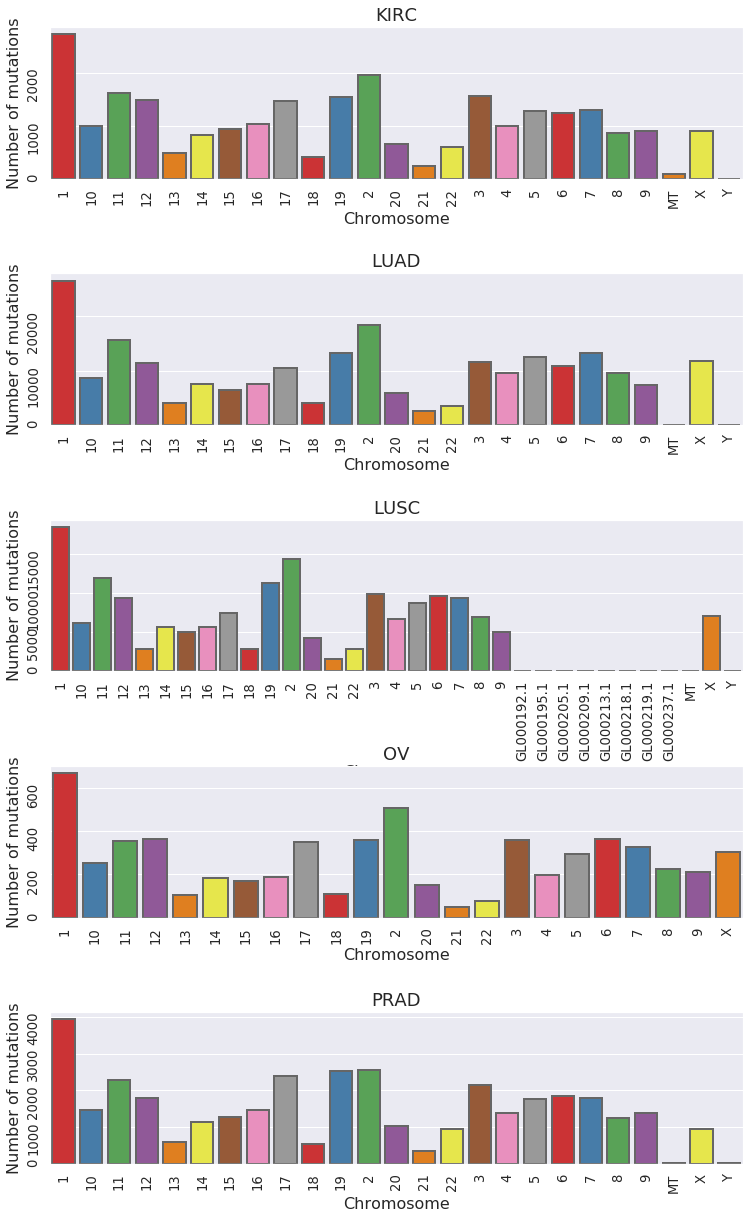

In [13]:
# Visualizing chromosome occurences as barplots for every cancer type
keys = list(mutations.keys())
fig, axes = plt.subplots( nrows=5, ncols=1, figsize=(12, 18) )
fig.tight_layout(pad=4.5)
for i in range(0,5):
    data2plot = mutations.get(keys[i]).groupby("Chrom")["Start_Position"].count()
    sns.barplot(x=data2plot.index, y=data2plot.values, palette="Set1", linewidth=2, edgecolor=".4",  ax=axes[i])
    axes[i].set_xlabel("Chromosome", fontsize=LABEL_SIZE)
    axes[i].set_ylabel("Number of mutations", fontsize=LABEL_SIZE)
    axes[i].tick_params(labelrotation=90)
    axes[i].set_title(keys[i], fontsize=TITLE_SIZE)

Below one can see all the occuring chromosomes in the .maf files:

In [14]:
# Check all the chromosomes occure
chromosomeSet = set()
for key in mutations:
    chromosomeSet = chromosomeSet | set(mutations.get(key)["Chrom"])
    
print("Chromosomes occure in .maf files:")
print(str(chromosomeSet)[1:-1])

Chromosomes occure in .maf files:
'10', '21', '18', '11', 'MT', '13', '14', 'GL000237.1', '12', '5', 'GL000213.1', 'GL000192.1', '19', 'GL000205.1', 'GL000209.1', 'GL000218.1', '1', '8', '7', '6', 'GL000195.1', 'Y', '20', '3', 'X', '9', '4', '15', 'GL000219.1', '16', '2', '17', '22'


### 4) Determining sequence context for an arbitrary genomic position

For the purpose of determining sequence context for an arbitrary genomic position, we will need for the hg19 human reference genome. A short reminder, *a reference genome (also known as a reference assembly) is a digital nucleic acid sequence database, assembled by scientists as a representative example of the set of genes in one idealized individual organism of a species. (source: https://en.wikipedia.org/wiki/Reference_genome)* 

According to the results above, we will download only the necessary reference genomes (listed above) and they will be renamed with agreement to .maf files. If you try to reproduce my work, you won't need to do this, all the necessary reference genome files can be downloaded from here: http://plaszkon.web.elte.hu/reference_genome.zip. Please unzip them to the folder *./reference_genome*

Originally, it can be (and was) downloaded from http://hgdownload.cse.ucsc.edu/goldenPath/hg19/chromosomes/. (The following steps are unnecessary, it has just description purpose!) As it is written on the webpage with the terminal command

$\hspace{2cm}$

<center>
    *wget --timestamping 'ftp://hgdownload.cse.ucsc.edu/goldenPath/hg19/chromosomes/chrM.fa.gz' -O chrM.fa.gz*
</center>

$\hspace{2cm}$

we can get the desired reference genomes, and they can be unziped with the command

$\hspace{2cm}$

<center>
    *gunzip $<$file$>$.fa.gz*.
</center>

$\hspace{2cm}$

The required reference genome files are downloaded and renamed according to the introduction of this chapter. All the files should be found in the *./reference_genome* folder. To load the necessary reference genomes, a function is defined:

$\hspace{2cm}$

<center>
    collect_reference_genomes( path )
</center>

$\hspace{2cm}$

And to get a nucleobase at a given position and its context, another function is defined too:

$\hspace{2cm}$

<center>
    get_sequence_context( referenceGenomes, chromosomeName, position, numberOfNeighbours )
</center>

$\hspace{2cm}$

This function reads a reference genome file sequentially, and gives back the nucleobase at a given position and its neighbours. Genomic position is defined by the name of the chromosome and the position of the base on that chromosome.

An example sequence can be seen here:

In [32]:
def collect_reference_genomes( path = "./reference_genome" ):
    """Load reference genomes (.fa files) from a folder.

    Parameters:
    path (string): the path of the folder which contains the fasta (.fa) files

    Returns:
    dictionary: containing loaded reference genomes"""
    
    def file_name_filter(fileName):
        return fileName[0:3] == "chr"
    
    fileNames = os.listdir(path)
    filteredFileNames = filter(file_name_filter, fileNames)
    
    referenceGenomeNames = []
    referenceGenomesFromFile = []
    
    for fileName in filteredFileNames:
        referenceGenomeNames.append( fileName[3:-3] )
        with open(path + "/" + fileName, 'r') as file:
            file.readline()
            data = file.read().replace('\n', '').upper()
        referenceGenomesFromFile.append( data )
    zip_iterator = zip(referenceGenomeNames, referenceGenomesFromFile)
    referenceGenomes = dict(zip_iterator)
    
    return referenceGenomes

In [33]:
def get_sequence_context( referenceGenomes, chromosomeName, position, numberOfNeighbours ):
    """Get sequence context around a given position

    Parameters:
    referenceGenomes (dictionary): a dictionary containing the required reference genome
    chromosomeName (string): the name of the chromosome to search
    position (integer): the position of the base
    numberOfNeighbours (integer): the number of left and right neighbours around the base position

    Returns:
    string: sequence context"""
    
    data = referenceGenomes.get(chromosomeName)
    return data[position-1-numberOfNeighbours:position+numberOfNeighbours]

In [34]:
# Reading reference genomes from the reference_genome folder
referenceGenomes = collect_reference_genomes( "./reference_genome" )

In [35]:
# An example sequence context
print("Example sequence:")
print(get_sequence_context(referenceGenomes, "Y",100000,50))

Example sequence:
TGTGTGTGTCCACACTTCCTCTCATGAGAACAGCAGGTTGCTTTAGGGCCCACCCTGACAGCCTCGTTCTAATACTATGAGGCCAAATACACTCACGTTCT


Based on the webpage https://genome-euro.ucsc.edu/cgi-bin/hgTracks?db=hg19&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr21%3A11111110%2D11111112&hgsid=275840646_e7bSzgLrALdhvWbzVOY8rpBBxySO, we can check if our own get_sequence_context function works properly or not. This happens below for some cases.

In [36]:
# chrY:6736166 -> CAT
print("Correct sequence context: CAT, result of the get_sequence_context function: "
      + get_sequence_context( referenceGenomes, "Y", 6736166, 1 ))

# chr1:2463579 -> GGC
print("Correct sequence context: GGC, result of the get_sequence_context function: "
      + get_sequence_context( referenceGenomes, "1", 2463579, 1 ))
      
# chrM:13579 -> TCG
print("Correct sequence context: TCG, result of the get_sequence_context function: "
      + get_sequence_context( referenceGenomes, "MT", 13579, 1 ))

# chr9:4638293 -> ACC
print("Correct sequence context: ACC, result of the get_sequence_context function: "
      + get_sequence_context( referenceGenomes, "9", 4638293, 1 ))

# chr21:111111 -> GGT
print("Correct sequence context: GGT, result of the get_sequence_context function: "
      + get_sequence_context( referenceGenomes, "21", 11111111, 1 ))

Correct sequence context: CAT, result of the get_sequence_context function: CAT
Correct sequence context: GGC, result of the get_sequence_context function: GGC
Correct sequence context: TCG, result of the get_sequence_context function: TCG
Correct sequence context: ACC, result of the get_sequence_context function: ACC
Correct sequence context: GGT, result of the get_sequence_context function: GGT


It may be an interesting question how much time we will need for all the evaluations. In the following I try to estimate it.

In [37]:
# Check required time
positions = [1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10]
requiredTimes = []
for pos in positions:
    start = time.time()
    get_sequence_context( referenceGenomes,"1", int(pos), 1 )
    end = time.time()
    requiredTimes.append(end-start)

In [38]:
# Calculate number of evaluations and average mutation position
totalLength = 0
totalSum = 0
for key in mutations:
    totalLength = totalLength + len(mutations.get(key))
    totalSum = totalSum + mutations.get(key)["Start_Position"].sum()
average = int(totalSum/totalLength)
print("Required number of evaluations: " + str(totalLength))
print("Average mutation position: " + str(average))

Required number of evaluations: 475034
Average mutation position: 81061471


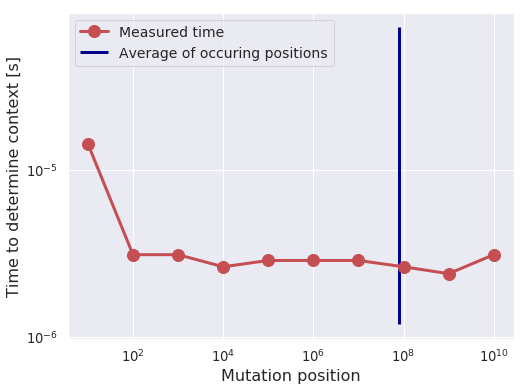

In [39]:
fig, ax = plt.subplots( figsize=(8, 6) )
ax.plot(positions, requiredTimes, 'ro-', markersize=12, linewidth=3, alpha=1.0, label="Measured time" )
ax.vlines(average, 0.5*min(requiredTimes), 5*max(requiredTimes), linewidth=3, color="darkblue", label="Average of occuring positions")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Mutation position", fontsize=LABEL_SIZE)
ax.set_ylabel("Time to determine context [s]", fontsize=LABEL_SIZE);
ax.legend(fontsize=LEGEND_SIZE, loc="upper left")
#fig.savefig("time.png")

As one can see, we can determine the sequence context at a given position very fast thanks to reading all fasta files into the memory.

Checking if the base found by the defined function is the same as the base listed in the Reference_Allele field. Some results can be seen below.

In [40]:
# Checks
toCheck = mutations.get("OV")[12:13]
print("(1)")
print("Expected: " + list(toCheck["Reference_Allele"])[0])
print("Result of get_sequence_context: " + get_sequence_context( referenceGenomes, list(toCheck["Chrom"])[0] , list(toCheck["Start_Position"])[0], 0 ) )

toCheck = mutations.get("KIRC")[15:16]
print("(2)")
print("Expected: " + list(toCheck["Reference_Allele"])[0])
print("Result of get_sequence_context: " + get_sequence_context( referenceGenomes, list(toCheck["Chrom"])[0] , list(toCheck["Start_Position"])[0], 0 ) )

toCheck = mutations.get("LUAD")[112:113]
print("(3)")
print("Expected: " + list(toCheck["Reference_Allele"])[0])
print("Result of get_sequence_context: " + get_sequence_context( referenceGenomes, list(toCheck["Chrom"])[0] , list(toCheck["Start_Position"])[0], 0 ) )

(1)
Expected: G
Result of get_sequence_context: G
(2)
Expected: A
Result of get_sequence_context: A
(3)
Expected: G
Result of get_sequence_context: G


Based on the previous checks we could assume, our function works properly.

### 5) Creating a mutational catalog for the 5 lists of somatic mutations separately

We are going to create a mutational catalog for the different cancer types. This means we are going to categorize the different kind of mutations. Six classes of base substitution exist:
- C>A
- C>G
- C>T
- T>A
- T>C
- T>G.

The G>T substitution is equivalent to the C>A substitution because it is not possible to differentiate on which DNA strand (forward or reverse) the substitution happpened. According to this, the C>A and G>T substitutions belong to the same (C>A) class. For the same reason the G>C, G>A, A>T, A>G and A>C mutations belong to the "C>G", "C>T", "T>A", "T>C" and "T>G" classes respectively. Taking into account the information from the neighbours - called 5' and 3' adjacent bases - 96 possible mutation types can be identified, because 5' and 3' adjacent bases can have 4-4 different "values": A, C, G or T. It is important, due to symmetry reason, 5' and 3' adjacent bases should be converted in a proper way when equivalences are considered in the substitution. This means we have to change place of the 5' and 3' bases and change the bases itself according to the following rules: G$\leftrightarrow$C, A$\leftrightarrow$T.  (https://en.wikipedia.org/wiki/Mutational_signatures)

In [41]:
# Defining 5' and 3' nucleotids and possible substitutions
_5nucleotids = ["A","C","G","T"]
_substitutions = ["[C>G]","[C>T]","[C>A]","[T>A]","[T>C]","[T>G]"]
_3nucleotids = ["A","C","G","T"]

# Creating mutational classes
mutationalClasses = []
for it1 in _substitutions:
    for it2 in _5nucleotids:
        for it3 in _3nucleotids:
            mutationalClasses.append(it2+it1+it3)

All the possible items in a catalog:

In [42]:
# The 96 mutation types
possibleMutationsTable = ff.create_table(np.append(np.array(['']*8), np.array(mutationalClasses)).reshape(13,8), height_constant=45)
possibleMutationsTable.layout.width = 600
py.offline.iplot(possibleMutationsTable, filename='Possible mutations')

In [43]:
def categorize_mutation(mutationalCatalog, context, mutation, UUID):
    """A function to categorize mutations and store them in a mutational catalog

    Parameters:
    mutationalCatalog (dataframe): a dataframe where the rows are the possible mutational classes, and columns will be the UUIDs. Mutations will be counted here.
    context (string): the context of the investigated mutation
    mutation (string): the value of the mutated base
    UUID (string): the unique sample identifier id
    """   
    
    def change_base( base ):
        if ( base == "G" ):
            return "C"
        elif ( base == "C" ):
            return "G"
        elif ( base == "A" ):
            return "T"
        elif ( base == "T" ):
            return "A"
    
    substitution = context[1] + ">" + mutation
    isEqualized = False
    if ( substitution == "G>T" ):
        substitution = "C>A"
        isEqualized = True
    if ( substitution == "G>C" ):
        substitution = "C>G"
        isEqualized = True
    if ( substitution == "G>A" ):
        substitution = "C>T"
        isEqualized = True
    if ( substitution == "A>T" ):
        substitution = "T>A"
        isEqualized = True
    if ( substitution == "A>G" ):
        substitution = "T>C"
        isEqualized = True
    if ( substitution == "A>C" ):
        substitution = "T>G"
        isEqualized = True
        
    if ( isEqualized ):
        tmpContext = list(context)
        tmpContext[0], tmpContext[2] = change_base( tmpContext[2] ), change_base( tmpContext[0] )
        context = "".join(tmpContext)
        
    toFind = context[0] + "[" + substitution + "]" + context[2]
    if UUID not in mutationalCatalog.columns:
        mutationalCatalog[UUID] = (mutationalCatalog.index == toFind).astype(int)
    else:
        mutationalCatalog[UUID] = mutationalCatalog[UUID] + (mutationalCatalog.index == toFind).astype(int)

In [44]:
def fill_catalog( catalogName, catalogVariable ):
    """A function to fill a catalog

    Parameters:
    catalogName (string): the name of the cancer type
    catalogVariable (dataframe): a mutational catalog, which will be filled
    """   
        
    table = mutations.get(catalogName)
    chroms = table["Chrom"]
    startPos = table["Start_Position"]
    mutation = table["Tumor_Seq_Allele2"]
    UUID = table["Tumor_Sample_UUID"]
    for i in range(0,len(table)):
        context = get_sequence_context( referenceGenomes, chroms[i], startPos[i], 1)
        categorize_mutation(catalogVariable, context, mutation[i], UUID[i])

In [45]:
# Creating empty catalogs
KIRCCatalog = pd.DataFrame( index = mutationalClasses )
LUADCatalog = pd.DataFrame( index = mutationalClasses )
LUSCCatalog = pd.DataFrame( index = mutationalClasses )
OVCatalog   = pd.DataFrame( index = mutationalClasses )
PRADCatalog = pd.DataFrame( index = mutationalClasses )

catalogsOrder = ["KIRC", "LUAD", "LUSC", "OV", "PRAD"]
catalogs = [KIRCCatalog, LUADCatalog, LUSCCatalog, OVCatalog, PRADCatalog]

# Filling the catalogs
fill_catalog( "KIRC", KIRCCatalog )
fill_catalog( "LUAD", LUADCatalog )
fill_catalog( "LUSC", LUSCCatalog )
fill_catalog( "OV",   OVCatalog )
fill_catalog( "PRAD", PRADCatalog )

As an example a part of the KIRC catalog can be seen here:

In [46]:
# An example of a catalog
KIRCCatalog.iloc[25:37,10:17]

05293342-027e-412b-ba3e-4be443ab44fe  \
G[C>T]C                                     6   
G[C>T]G                                     2   
G[C>T]T                                    10   
T[C>T]A                                    10   
T[C>T]C                                     2   
T[C>T]G                                     2   
T[C>T]T                                     2   
A[C>A]A                                     0   
A[C>A]C                                     2   
A[C>A]G                                     2   
A[C>A]T                                     2   
C[C>A]A                                     0   

         58ed1281-f5b3-4f5c-89b5-650450010cd5  \
G[C>T]C                                    18   
G[C>T]G                                    22   
G[C>T]T                                     8   
T[C>T]A                                     4   
T[C>T]C                                    11   
T[C>T]G                                     0   
T[C>T]T                                     0   
A[C>A]A                                     0   
A[C>A]C                                     2   
A[C>A]G                                     0   
A[C>A]T                                     2   
C[C>A]A                                     4   

         5365a094-7a92-4649-96fc-836a70647bbe  \
G[C>T]C                                    13   
G[C>T]G                                    16   
G[C>T]T                                     6   
T[C>T]A                                     0   
T[C>T]C                                     8   
T[C>T]G                                     2   
T[C>T]T                                     4   
A[C>A]A                                     5   
A[C>A]C                                     4   
A[C>A]G                                     0   
A[C>A]T                                     4   
C[C>A]A                                     4   

         d4038a83-179f-407c-b5cb-5ca5225ddb4f  \
G[C>T]C                                    34   
G[C>T]G                                    24   
G[C>T]T                                     2   
T[C>T]A                                     7   
T[C>T]C                                    12   
T[C>T]G                                     7   
T[C>T]T                                     8   
A[C>A]A                                     6   
A[C>A]C                                     2   
A[C>A]G                                     0   
A[C>A]T                                     4   
C[C>A]A                                    10   

         9f790e7e-3475-4242-82fc-cbdd461ce5ef  \
G[C>T]C                                    11   
G[C>T]G                                     2   
G[C>T]T                                     4   
T[C>T]A                                     1   
T[C>T]C                                     3   
T[C>T]G                                     4   
T[C>T]T                                     2   
A[C>A]A                                     1   
A[C>A]C                                     2   
A[C>A]G                                     0   
A[C>A]T                                     1   
C[C>A]A                                     3   

         261de0a2-6006-4b3b-aac0-37d9b33840aa  \
G[C>T]C                                    13   
G[C>T]G                                     5   
G[C>T]T                                     1   
T[C>T]A                                     3   
T[C>T]C                                     4   
T[C>T]G                                     4   
T[C>T]T                                     3   
A[C>A]A                                     1   
A[C>A]C                                     1   
A[C>A]G                                     0   
A[C>A]T                                     1   
C[C>A]A                                     1   

         b1b7b8e8-cc87-4a52-900a-1f3ef7d449d7  
G[C>T]C                                     3  
G[C>T]G                                     1  
G[C>T]T                              

And now you can check the different mutational catalogs. It is possible to change the number of mutations and number of UUIDs to show. (It can be seen only if you run it as an .ipynb)

In [47]:
# Comment out to create static heatmap
#fig, ax = plt.subplots( figsize=(12, 16) )
#sns.heatmap(LUADCatalog.iloc[:,0:200])
#ax.set_title("Part of the LUAC catalog", fontsize=30)

In [48]:
def interactive_catalogs(cancerType, mutationMin, mutationMax, uuidMin, uuidMax):
    if( cancerType=="LUAD" ):
        return LUADCatalog.iloc[mutationMin-1:mutationMax,uuidMin:uuidMax]
    elif( cancerType=="KIRC" ):
        return KIRCCatalog.iloc[mutationMin-1:mutationMax,uuidMin:uuidMax]
    elif( cancerType=="LUSC" ):
        return LUSCCatalog.iloc[mutationMin-1:mutationMax,uuidMin:uuidMax]
    elif( cancerType=="OV" ):
        return OVCatalog.iloc[mutationMin-1:mutationMax,uuidMin:uuidMax]
    elif( cancerType=="PRAD" ):
        return PRADCatalog.iloc[mutationMin-1:mutationMax,uuidMin:uuidMax]
    
def visualize_catalog(cancerType, mutation, uuid):
    toPlot = interactive_catalogs(cancerType, mutation[0], mutation[1], uuid[0], uuid[1])
    fig, ax = plt.subplots( figsize=(10, 10) )
    sns.heatmap(np.log(toPlot+1))
    ax.set_title(cancerType + " catalog on logarithmic scale", fontsize=30)
    
interact(visualize_catalog,
         cancerType=Dropdown(options=['LUAD', 'KIRC', 'LUSC', 'OV', 'PRAD'],description='Cancer type'),
         mutation=IntRangeSlider(value=[1, 96], min=1, max=96, step=1, description='Mutations'),
         uuid=IntRangeSlider(value=[1, 142], min=1, max=561, step=1, description='UUIDs')
        );

interactive(children=(Dropdown(description='Cancer type', options=('LUAD', 'KIRC', 'LUSC', 'OV', 'PRAD'), value='LUAD'), IntRangeSlider(value=(1, 96), description='Mutations', max=96, min=1), IntRangeSlider(value=(1, 142), description='UUIDs', max=561, min=1), Output()), _dom_classes=('widget-interact',))

And also, let's check how many mutations we have:

In [49]:
# Let's check the number of mutations
for i in range(0,5):
    print("The number of samples in case of " + catalogsOrder[i] + ": " + str(len(catalogs[i].columns)))
    print("The number of somatic mutations in case of " + catalogsOrder[i] + ": " + str(np.sum(np.sum(catalogs[i]))))

The number of samples in case of KIRC: 235
The number of somatic mutations in case of KIRC: 26245
The number of samples in case of LUAD: 561
The number of somatic mutations in case of LUAD: 232492
The number of samples in case of LUSC: 497
The number of somatic mutations in case of LUSC: 173223
The number of samples in case of OV: 142
The number of somatic mutations in case of OV: 6174
The number of samples in case of PRAD: 499
The number of somatic mutations in case of PRAD: 36805


### 6) Performing non-negative matrix factorization to extract signatures

The next step is a non-negative matrix factorization. For this task we will need some norm, so the following "norms" are defined:
- **Sample Max Norm:** every sample is divided by the maximum number of mutations of the given sample,
- **Mutation Max Norm:** every mutation is divided by mutation's maximal number of occurence on the samples,
- **Sample Sum Norm:** in every sample the sum of the value of mutations is equal to 1,
- **Mutation Sum Norm:** in every mutation the sum of the occurence value in samples is equal to 1.

In [53]:
# Defining the norms
def norm_sample_max( catalog ):
    catalogArray = np.array(catalog)
    normFactors = np.max(catalogArray, axis=0)
    return catalogArray/normFactors, normFactors

def norm_mutation_max( catalog ):
    catalogArray = np.array(catalog)
    normFactors = np.max(catalogArray, axis=1)
    return (catalogArray.T/normFactors).T, normFactors.T

def norm_sample_sum( catalog ):
    catalogArray = np.array(catalog)
    normFactors = np.sum(catalogArray, axis=0)
    return catalogArray/normFactors, normFactors

def norm_mutation_sum( catalog ):
    catalogArray = np.array(catalog)
    normFactors = np.sum(catalogArray, axis=1)
    return (catalogArray.T/normFactors).T, normFactors.T

For non-negative matrix factorization we will use the NMF model of Scikit Learn. The parameter space provided by the implementation is the following:
- n_components
- alpha
- l1_ratio

We need to find the best parameters and choose the best normalization. According to article [1] and [2] there exist only a few signatures which are responsible for different kind of cancers. This is encoded by the number of components of the NMF (n_components), so we will try to keep this value not too high (optimally 3-7). We are going to use Frobenius-norm to measure the reconstruction error, so to minimize this, l1_ratio will be set to 0 (this means we are going to optimalize our modell according to the Frobenius-norm). So there is only one parameter - alpha - which is in relation with the regularization terms too (for more details, read https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html). We will look for the best alpha for every cancer types and every normalization. Reconstruction rate is calculated by Scikit. Best alpha is found by hand.

#### a) Without normalization

Best alphas:
- KIRC: $\alpha =$ 70
- LUAD: $\alpha =$ 150
- LUSC: $\alpha =$ 150
- OV: $\alpha =$ 17
- PRAD: $\alpha =$ 50

Average reconstruction rate and the logarithm of its standard deviation [log(RSD)] can be seen here:

/home/nplaszko/.conda/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning:

divide by zero encountered in log



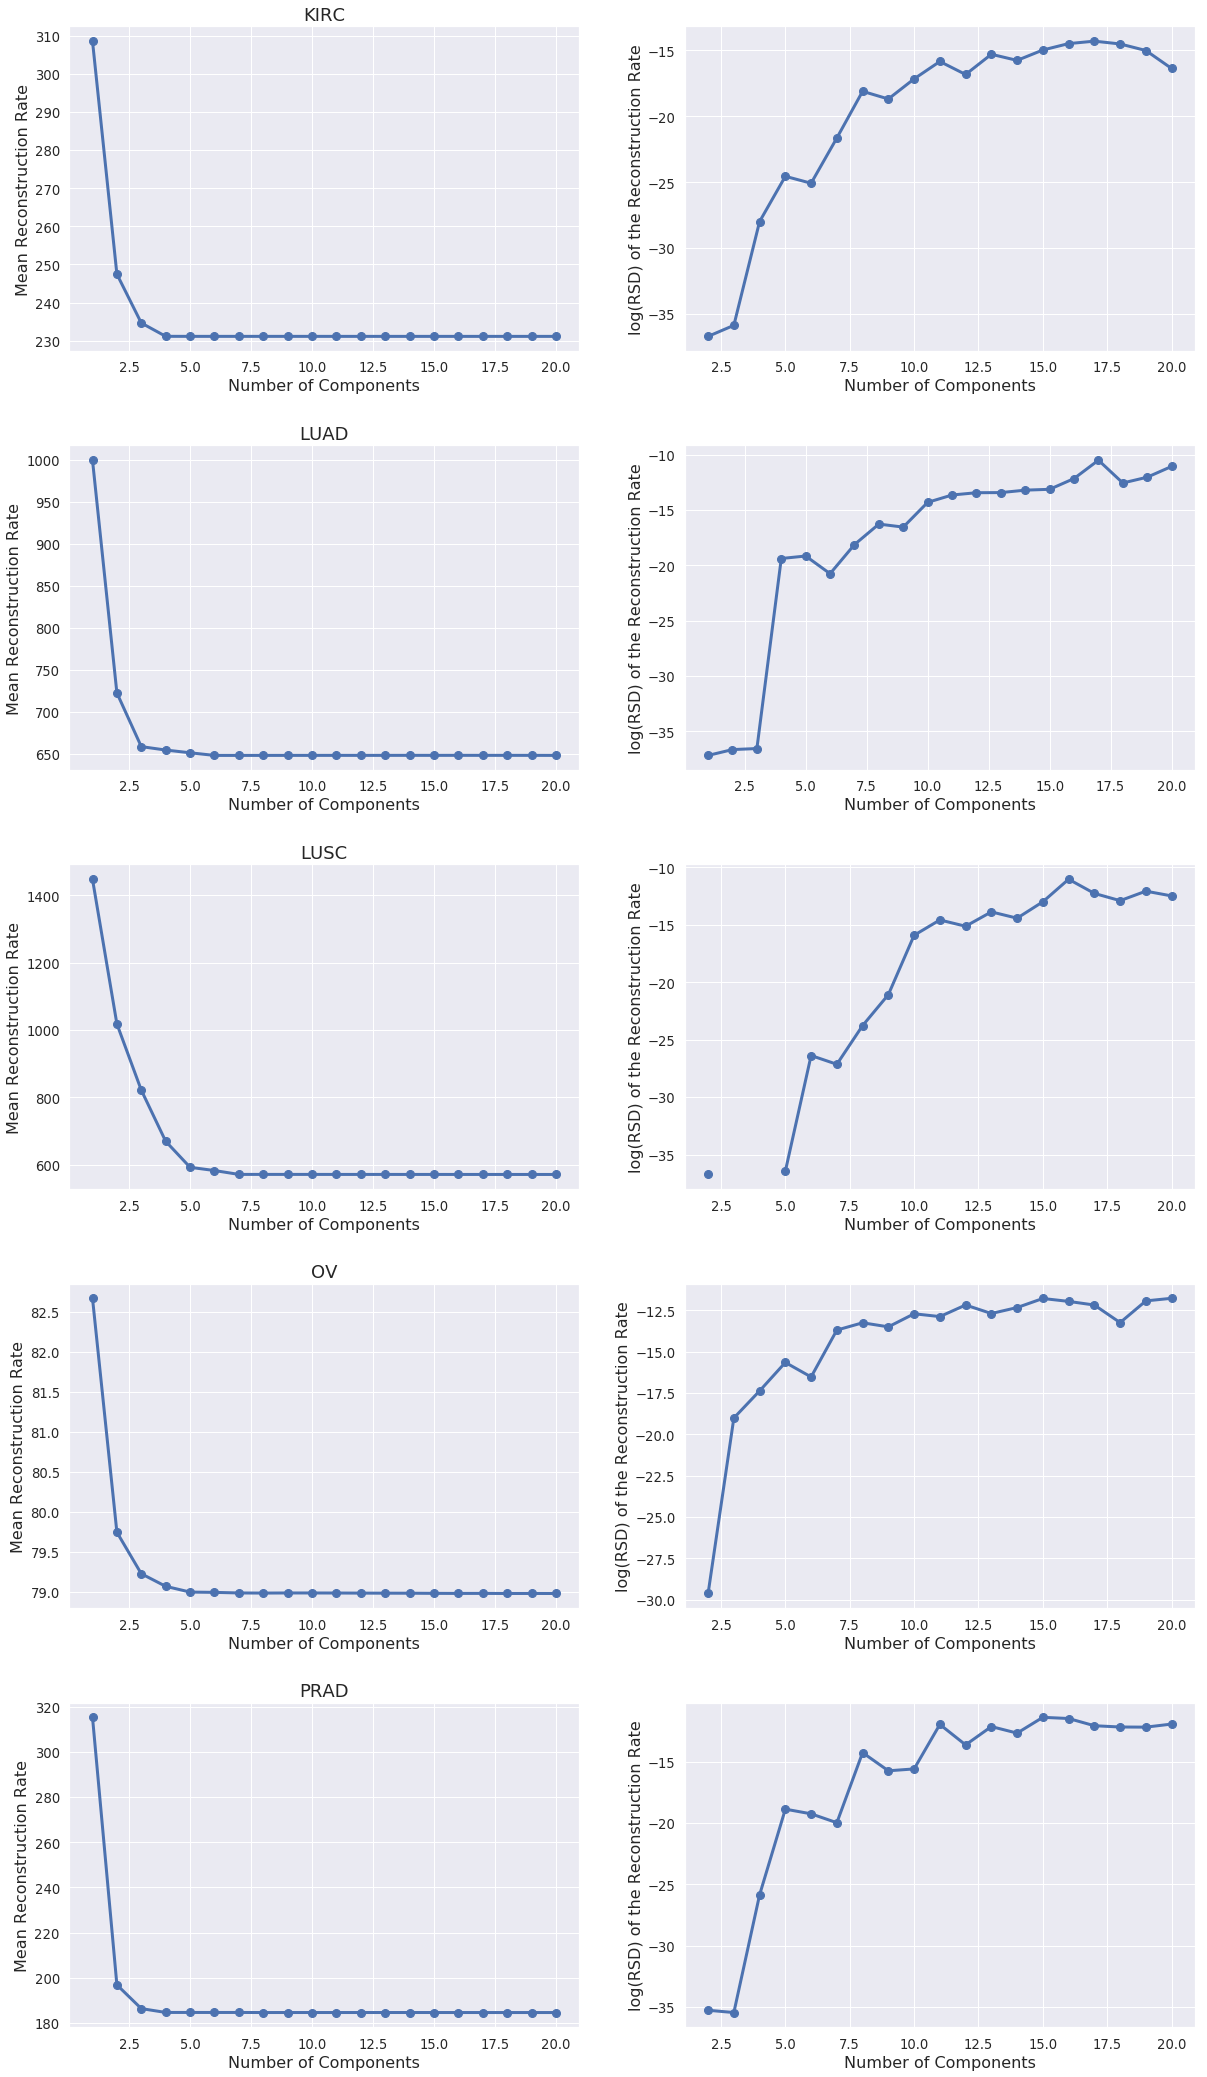

In [54]:
alphasWithoutNorm = [70,150,150,17,50]
nComponents = np.arange(1,21)

fig, axes = plt.subplots( nrows=5, ncols=2, figsize=(18, 30) )
fig.tight_layout(pad=4.5)

for i in range(0,5):
    recMeanError = []
    recStd = []
    
    for num in nComponents:
        tmpRecErr = []
        for k in range(0,5):
            model = NMF(n_components=num, init='nndsvd', alpha=alphasWithoutNorm[i], l1_ratio=0 )
            W = model.fit_transform(catalogs[i])
            tmpRecErr.append(model.reconstruction_err_)
        recMeanError.append(np.mean(tmpRecErr))
        recStd.append(np.std(tmpRecErr))

    axes[i, 0].set_title(catalogsOrder[i], fontsize=TITLE_SIZE)
    axes[i, 0].plot(nComponents,recMeanError,'o-', lw=3, ms=8 )
    axes[i, 0].set_xlabel("Number of Components", fontsize=LABEL_SIZE)
    axes[i, 0].set_ylabel("Mean Reconstruction Rate", fontsize=LABEL_SIZE)    
    axes[i, 1].plot(nComponents,np.log(np.array(recStd)/np.array(recMeanError)),'o-', lw=3, ms=8 )
    axes[i, 1].set_xlabel("Number of Components", fontsize=LABEL_SIZE)
    axes[i, 1].set_ylabel("log(RSD) of the Reconstruction Rate", fontsize=LABEL_SIZE)

#### b) With Sample Max Norm

Best alphas:
- KIRC: $\alpha =$ 5
- LUAD: $\alpha =$ 5
- LUSC: $\alpha =$ 5
- OV: $\alpha =$ 5
- PRAD: $\alpha =$ 5

Average reconstruction rate and the logarithm of its standard deviation [log(RSD)] can be seen here:

/home/nplaszko/.conda/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning:

divide by zero encountered in log



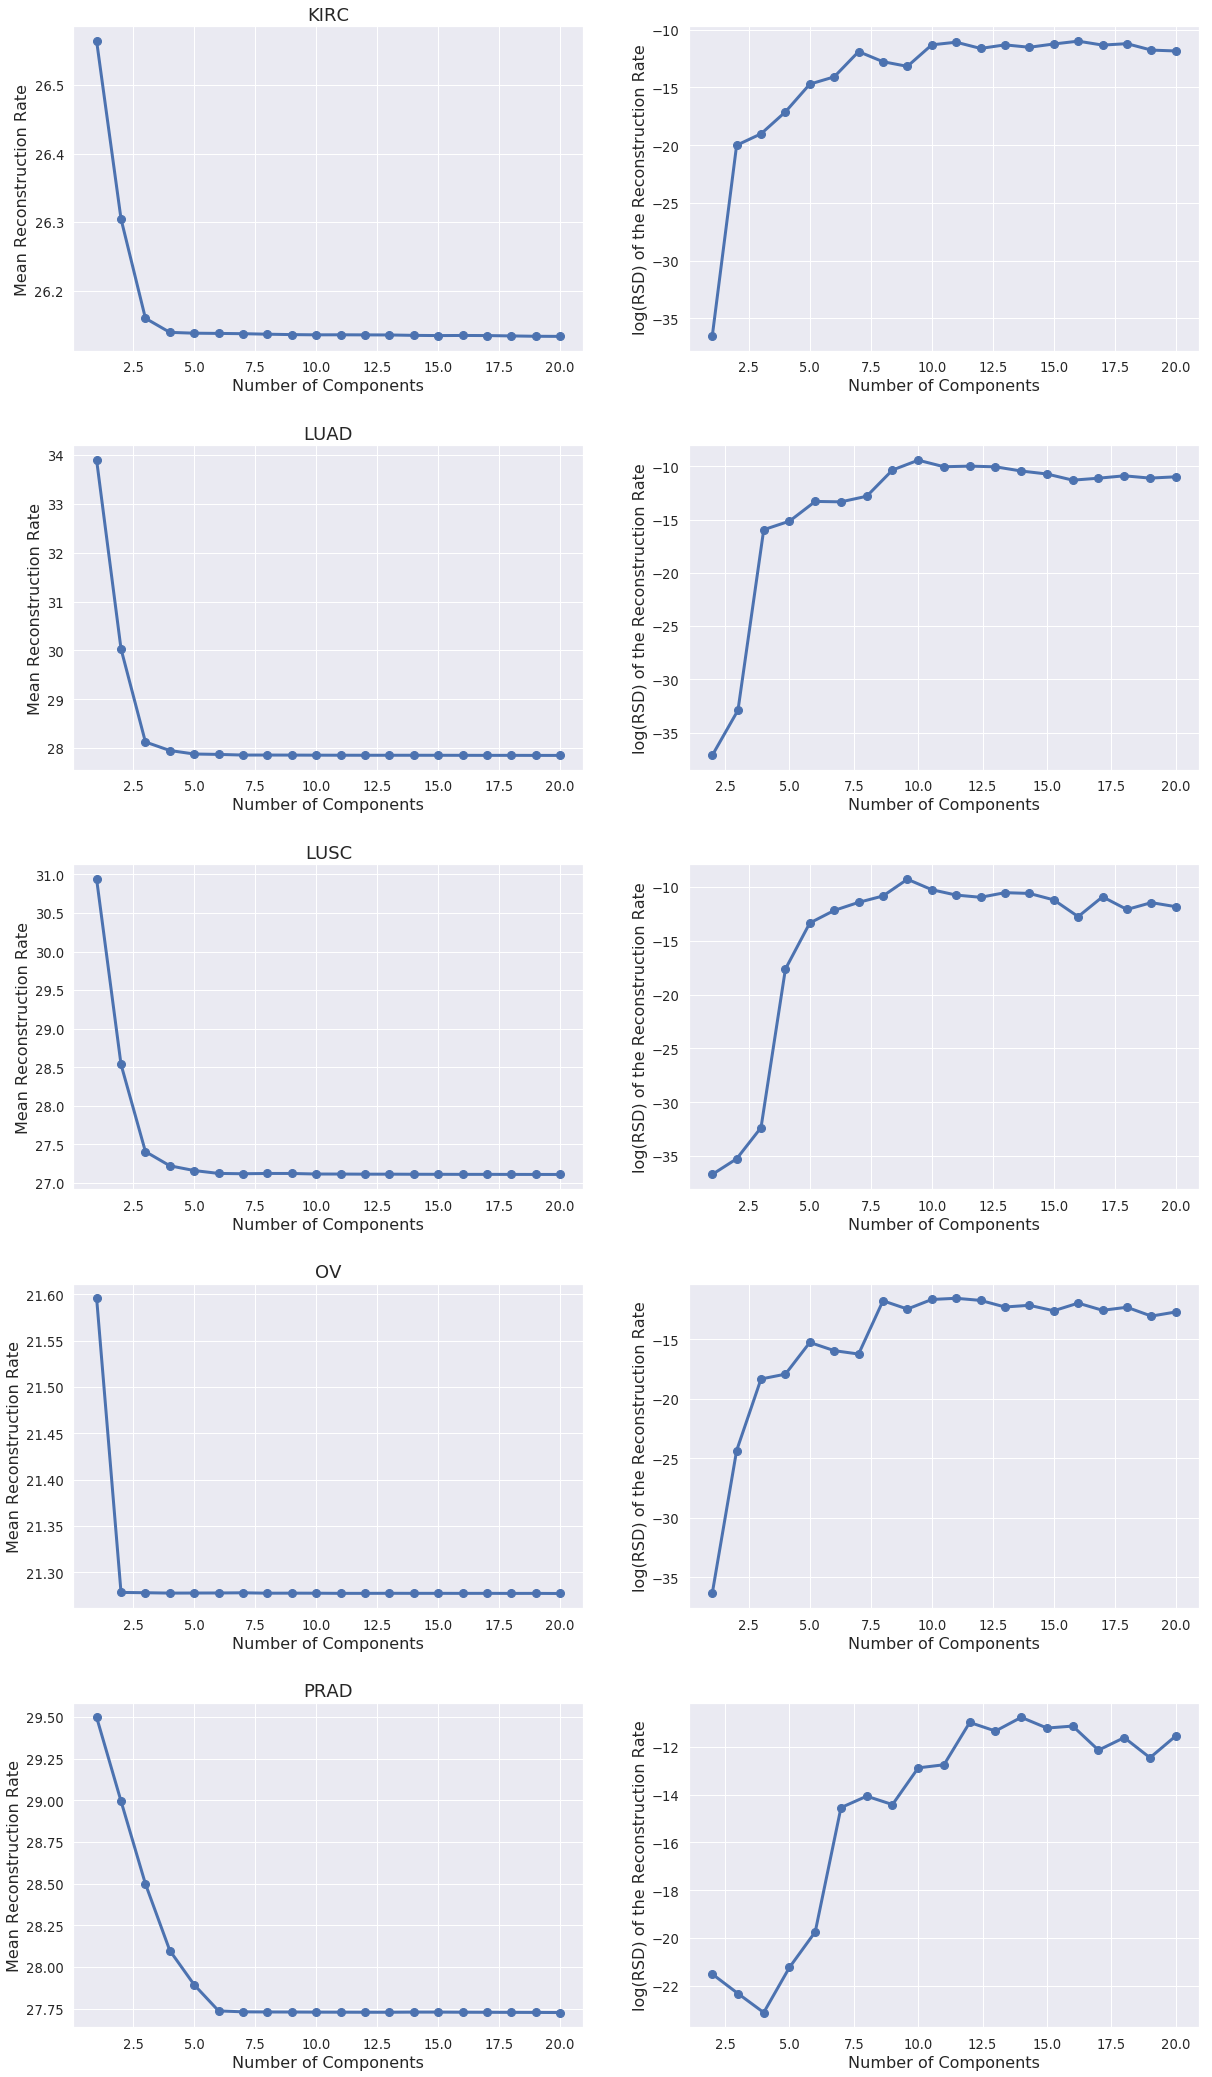

In [55]:
alphasSampleMaxNorm = [5,5,5,5,5]
nComponents = np.arange(1,21)

fig, axes = plt.subplots( nrows=5, ncols=2, figsize=(18, 30) )
fig.tight_layout(pad=4.5)

for i in range(0,5):
    recMeanError = []
    recStd = []
    
    for num in nComponents:
        tmpRecErr = []
        for k in range(0,10):
            model = NMF(n_components=num, init='nndsvd', alpha=alphasSampleMaxNorm[i], l1_ratio=0 )
            W = model.fit_transform(norm_sample_max(catalogs[i])[0])
            tmpRecErr.append(model.reconstruction_err_)
        recMeanError.append(np.mean(tmpRecErr))
        recStd.append(np.std(tmpRecErr))

    axes[i, 0].set_title(catalogsOrder[i], fontsize=TITLE_SIZE)
    axes[i, 0].plot(nComponents,recMeanError,'o-', lw=3, ms=8 )
    axes[i, 0].set_xlabel("Number of Components", fontsize=LABEL_SIZE)
    axes[i, 0].set_ylabel("Mean Reconstruction Rate", fontsize=LABEL_SIZE)    
    axes[i, 1].plot(nComponents,np.log(np.array(recStd)/np.array(recMeanError)),'o-', lw=3, ms=8 )
    axes[i, 1].set_xlabel("Number of Components", fontsize=LABEL_SIZE)
    axes[i, 1].set_ylabel("log(RSD) of the Reconstruction Rate", fontsize=LABEL_SIZE)

#### c) With Mutation Max Norm

Best alphas:
- KIRC: $\alpha =$ 4
- LUAD: $\alpha =$ 4
- LUSC: $\alpha =$ 4
- OV: $\alpha =$ 5
- PRAD: $\alpha =$ 4.5

Average reconstruction rate and the logarithm of its standard deviation [log(RSD)] can be seen here:

/home/nplaszko/.conda/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning:

divide by zero encountered in log



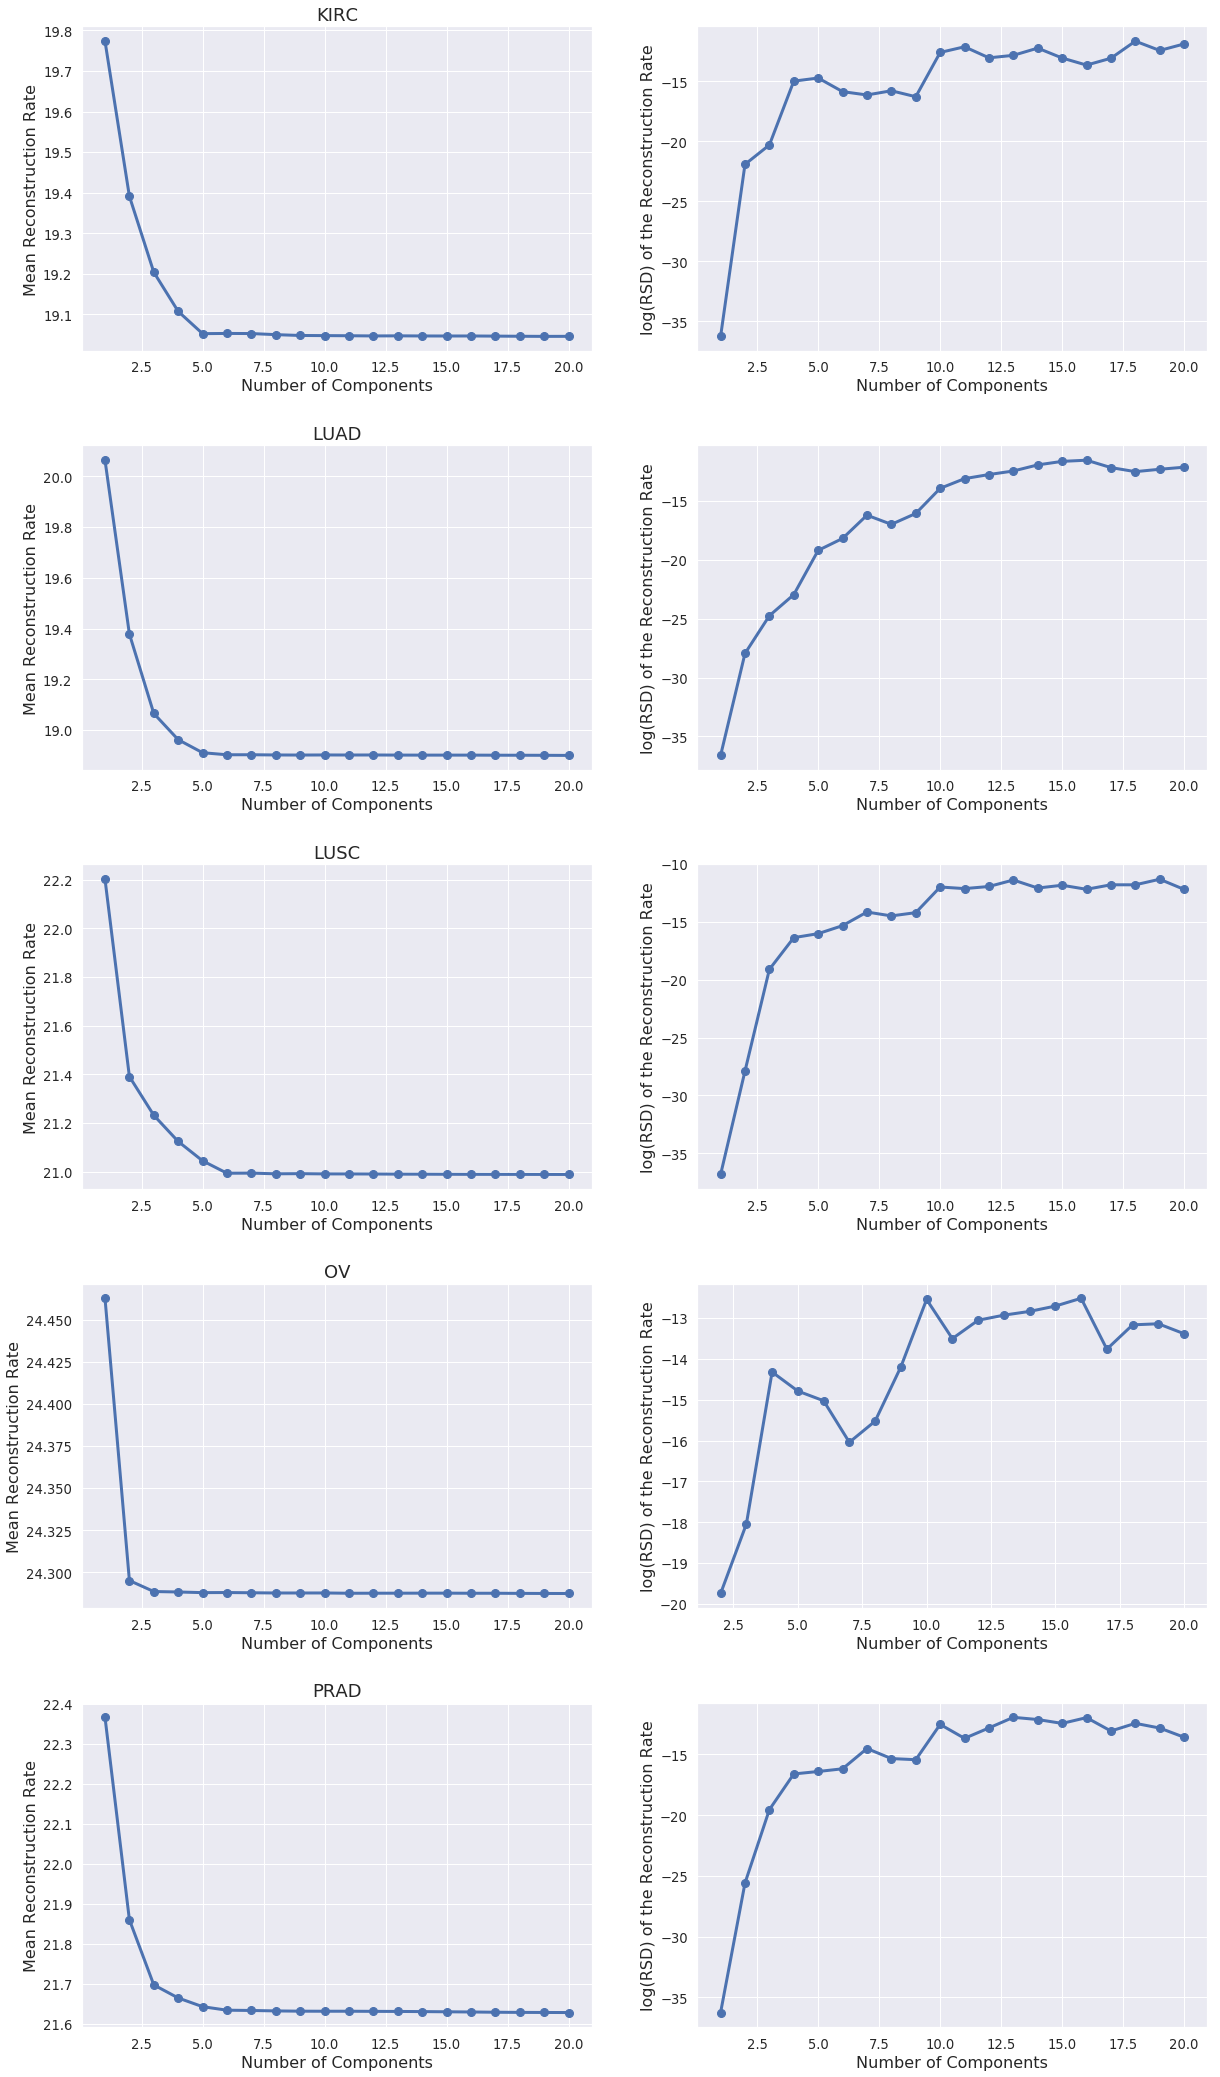

In [56]:
alphasMutationMaxNorm = [4,4,4,5,4.5]
nComponents = np.arange(1,21)

fig, axes = plt.subplots( nrows=5, ncols=2, figsize=(18, 30) )
fig.tight_layout(pad=4.5)

for i in range(0,5):
    recMeanError = []
    recStd = []
    
    for num in nComponents:
        tmpRecErr = []
        for k in range(0,10):
            model = NMF(n_components=num, init='nndsvd', alpha=alphasMutationMaxNorm[i], l1_ratio=0 )
            W = model.fit_transform(norm_mutation_max(catalogs[i])[0])
            tmpRecErr.append(model.reconstruction_err_)
        recMeanError.append(np.mean(tmpRecErr))
        recStd.append(np.std(tmpRecErr))

    axes[i, 0].set_title(catalogsOrder[i], fontsize=TITLE_SIZE)
    axes[i, 0].plot(nComponents,recMeanError,'o-', lw=3, ms=8 )
    axes[i, 0].set_xlabel("Number of Components", fontsize=LABEL_SIZE)
    axes[i, 0].set_ylabel("Mean Reconstruction Rate", fontsize=LABEL_SIZE)    
    axes[i, 1].plot(nComponents,np.log(np.array(recStd)/np.array(recMeanError)),'o-', lw=3, ms=8 )
    axes[i, 1].set_xlabel("Number of Components", fontsize=LABEL_SIZE)
    axes[i, 1].set_ylabel("log(RSD) of the Reconstruction Rate", fontsize=LABEL_SIZE)

#### d) With sample sum norm
Best alphas:
- KIRC: $\alpha =$ 0.4
- LUAD: $\alpha =$ 0.45
- LUSC: $\alpha =$ 0.5
- OV: $\alpha =$ 1.0
- PRAD: $\alpha =$ 0.9

Average reconstruction rate and the logarithm of its standard deviation [log(RSD)] can be seen here:

/home/nplaszko/.conda/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning:

divide by zero encountered in log



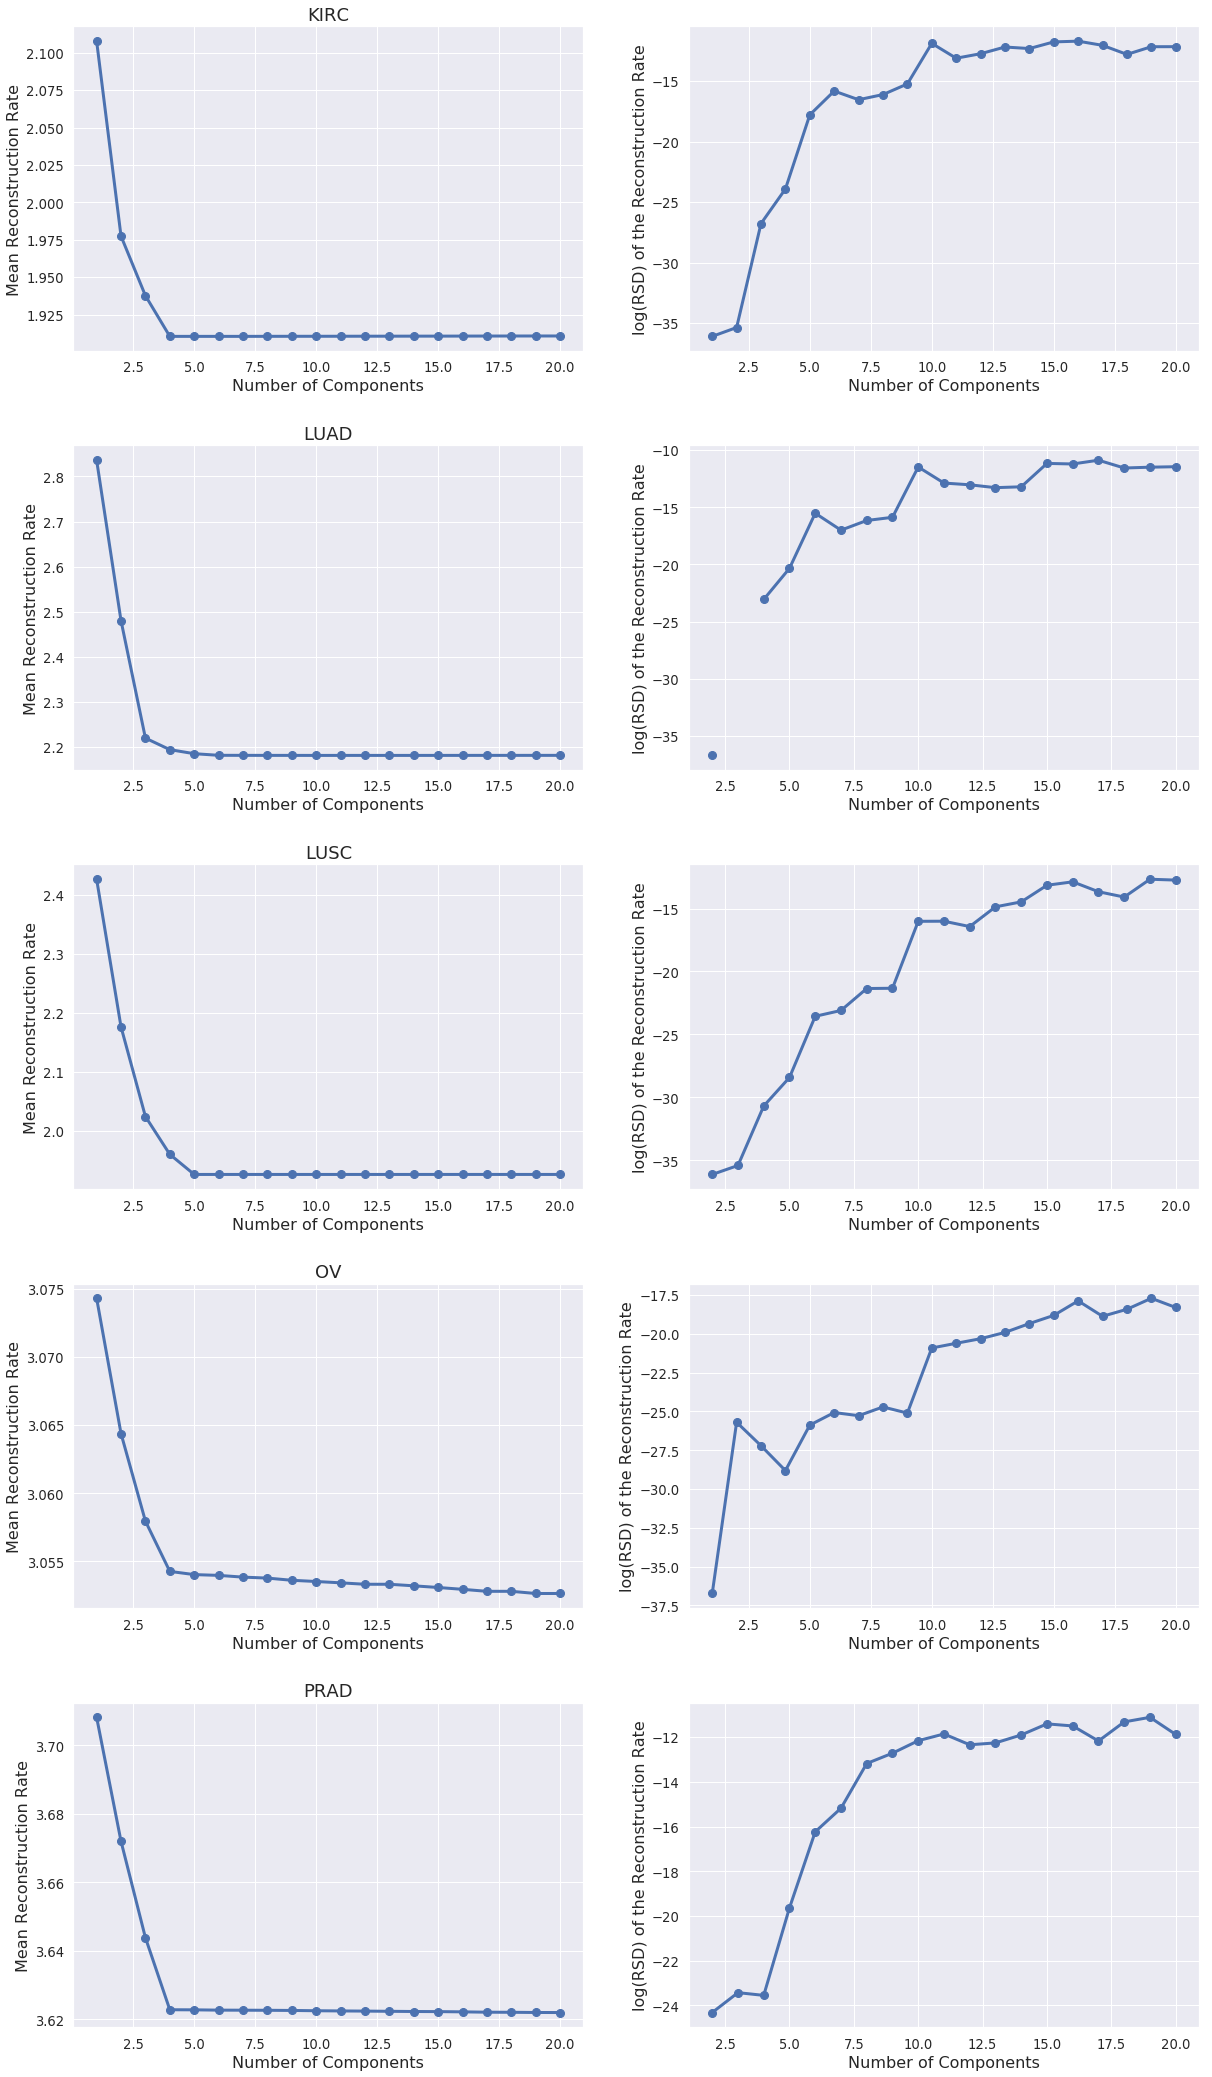

In [57]:
alphasSampleSumNorm = [0.40,0.45,0.5,1.0,0.9]
nComponents = np.arange(1,21)

fig, axes = plt.subplots( nrows=5, ncols=2, figsize=(18, 30) )
fig.tight_layout(pad=4.5)

for i in range(0,5):
    recMeanError = []
    recStd = []
    
    for num in nComponents:
        tmpRecErr = []
        for k in range(0,10):
            model = NMF(n_components=num, init='nndsvd', alpha=alphasSampleSumNorm[i], l1_ratio=0 )
            W = model.fit_transform(norm_sample_sum(catalogs[i])[0])
            tmpRecErr.append(model.reconstruction_err_)
        recMeanError.append(np.mean(tmpRecErr))
        recStd.append(np.std(tmpRecErr))

    axes[i, 0].set_title(catalogsOrder[i], fontsize=TITLE_SIZE)
    axes[i, 0].plot(nComponents,recMeanError,'o-', lw=3, ms=8 )
    axes[i, 0].set_xlabel("Number of Components", fontsize=LABEL_SIZE)
    axes[i, 0].set_ylabel("Mean Reconstruction Rate", fontsize=LABEL_SIZE)    
    axes[i, 1].plot(nComponents,np.log(np.array(recStd)/np.array(recMeanError)),'o-', lw=3, ms=8 )
    axes[i, 1].set_xlabel("Number of Components", fontsize=LABEL_SIZE)
    axes[i, 1].set_ylabel("log(RSD) of the Reconstruction Rate", fontsize=LABEL_SIZE)

#### e) With mutation sum norm

Best alphas:
- KIRC: $\alpha =$ 0.2
- LUAD: $\alpha =$ 0.1
- LUSC: $\alpha =$ 0.1
- OV: $\alpha =$ 0.33
- PRAD: $\alpha =$ 0.15

Average reconstruction rate and the logarithm of its standard deviation [log(RSD)] can be seen here:

/home/nplaszko/.conda/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning:

divide by zero encountered in log



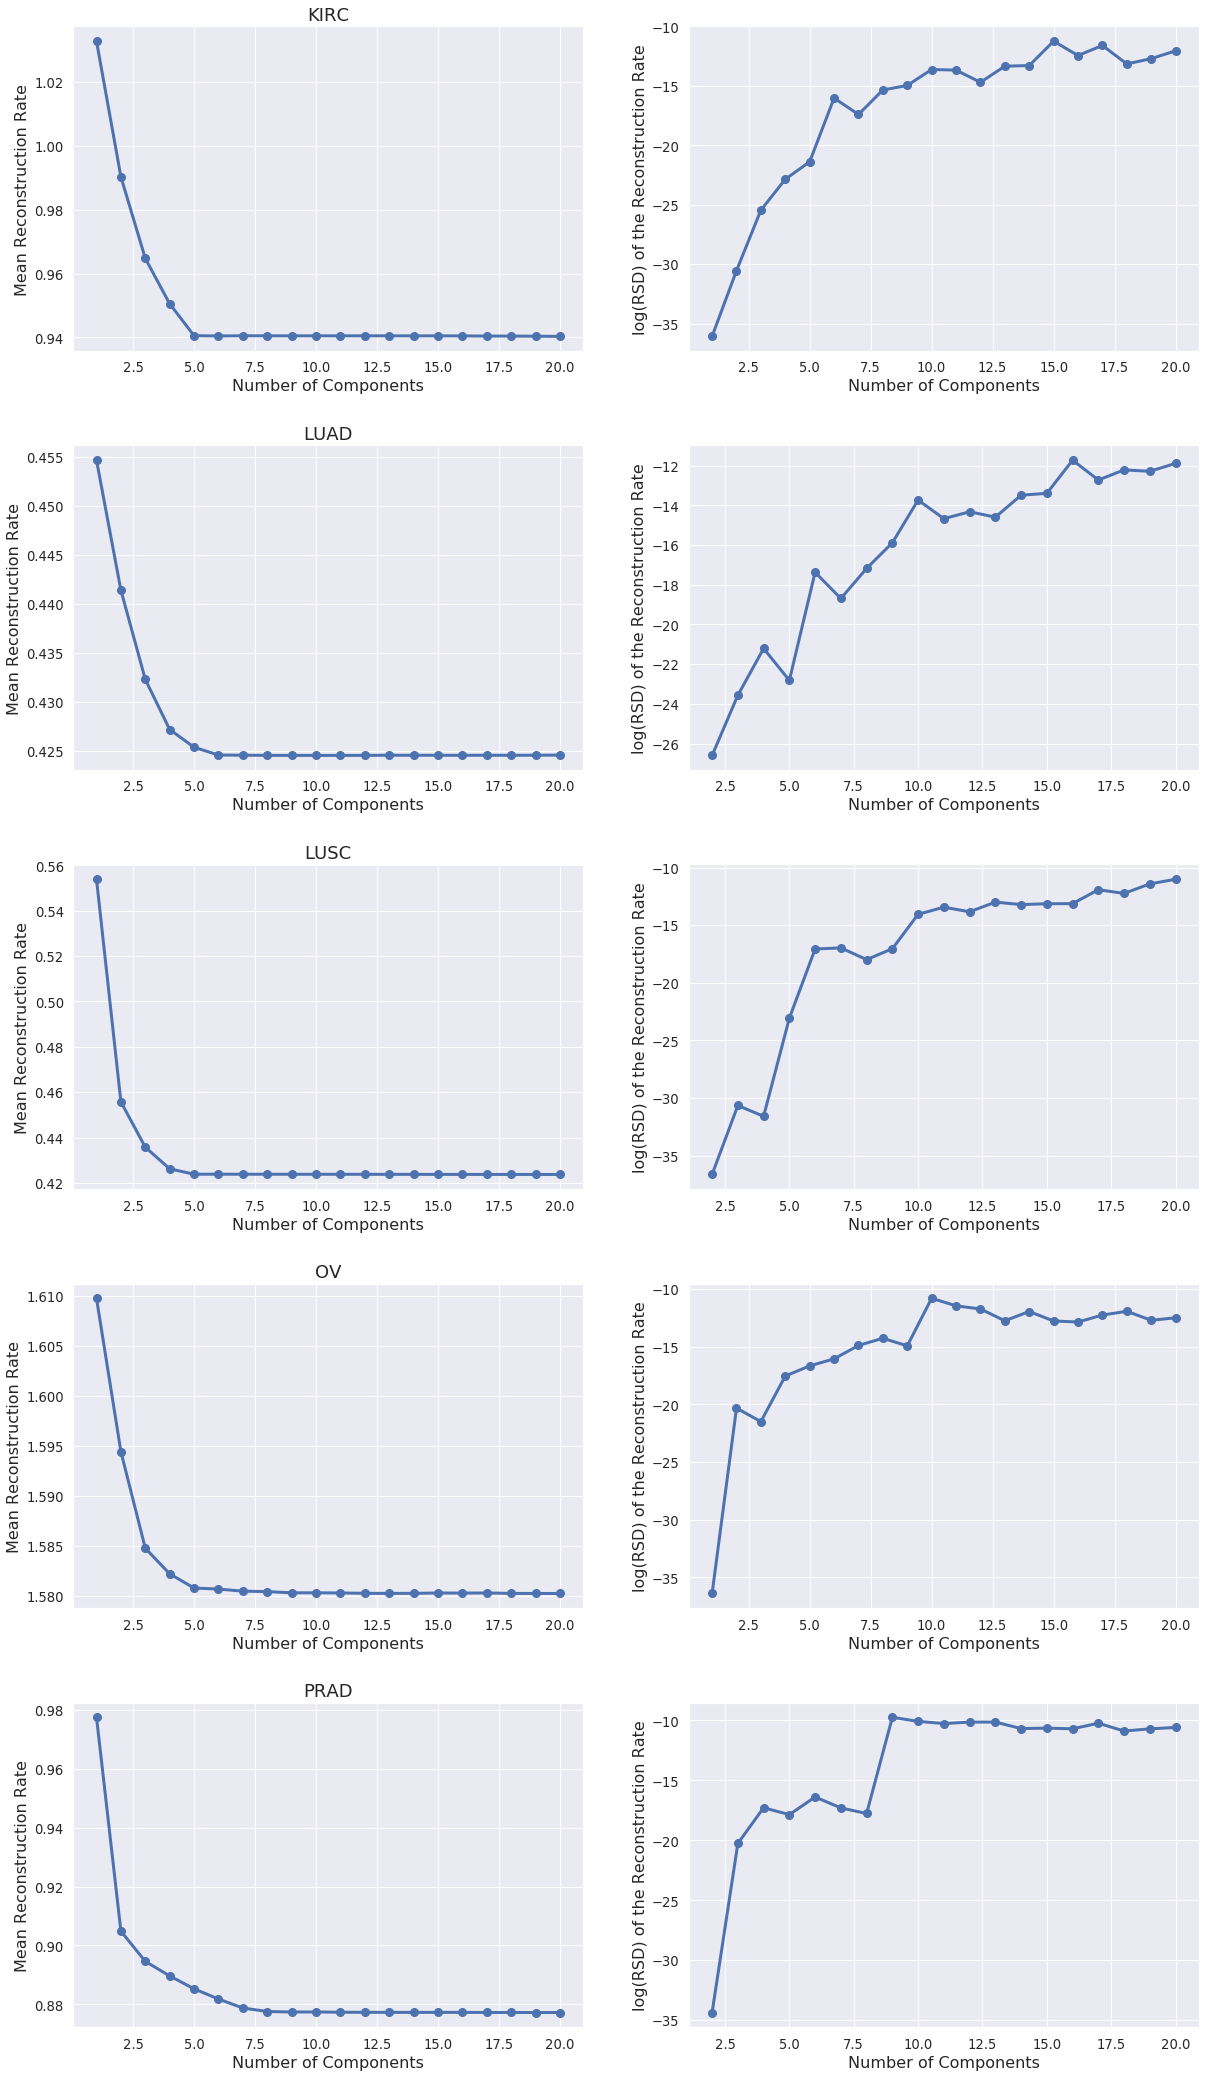

In [58]:
alphasMutationSumNorm = [0.2,0.1,0.1,0.33,0.15]
nComponents = np.arange(1,21)

fig, axes = plt.subplots( nrows=5, ncols=2, figsize=(18, 30) )
fig.tight_layout(pad=4.5)

for i in range(0,5):
    recMeanError = []
    recStd = []
    
    for num in nComponents:
        tmpRecErr = []
        for k in range(0,10):
            model = NMF(n_components=num, init='nndsvd', alpha=alphasMutationSumNorm[i], l1_ratio=0 )
            W = model.fit_transform(norm_mutation_sum(catalogs[i])[0])
            tmpRecErr.append(model.reconstruction_err_)
        recMeanError.append(np.mean(tmpRecErr))
        recStd.append(np.std(tmpRecErr))

    axes[i, 0].set_title(catalogsOrder[i], fontsize=TITLE_SIZE)
    axes[i, 0].plot(nComponents,recMeanError,'o-', lw=3, ms=8 )
    axes[i, 0].set_xlabel("Number of Components", fontsize=LABEL_SIZE)
    axes[i, 0].set_ylabel("Mean Reconstruction Rate", fontsize=LABEL_SIZE)    
    axes[i, 1].plot(nComponents,np.log(np.array(recStd)/np.array(recMeanError)),'o-', lw=3, ms=8 )
    axes[i, 1].set_xlabel("Number of Components", fontsize=LABEL_SIZE)
    axes[i, 1].set_ylabel("log(RSD) of the Reconstruction Rate", fontsize=LABEL_SIZE)

Appropriate alphas were chosen for every case. Now the best normalization method can be chosen by comparing the log(RSD) values. Although hard to decide, but based on the log(RSD) sample-max normalization seems the most roboust. And in every cancer types we will keep 6 components. With this properties NMF was carried out in every case of every cancer types.

In [59]:
# Making final NMF

KIRCModel = NMF(n_components=6, init='nndsvd', alpha=5, l1_ratio=0 )
KIRCW = KIRCModel.fit_transform(norm_sample_max(KIRCCatalog)[0])
KIRCH = KIRCModel.components_

LUADModel = NMF(n_components=6, init='nndsvd', alpha=5, l1_ratio=0 )
LUADW = LUADModel.fit_transform(norm_sample_max(LUADCatalog)[0])
LUADH = LUADModel.components_

LUSCModel = NMF(n_components=6, init='nndsvd', alpha=5, l1_ratio=0 )
LUSCW = LUSCModel.fit_transform(norm_sample_max(LUSCCatalog)[0])
LUSCH = LUSCModel.components_

OVModel = NMF(n_components=6, init='nndsvd', alpha=5, l1_ratio=0 )
OVW = OVModel.fit_transform(norm_sample_max(OVCatalog)[0])
OVH = OVModel.components_

PRADModel = NMF(n_components=6, init='nndsvd', alpha=5, l1_ratio=0 )
PRADW = PRADModel.fit_transform(norm_sample_max(PRADCatalog)[0])
PRADH = PRADModel.components_

models = [KIRCModel, LUADModel, LUSCModel, OVModel, PRADModel]
W = [KIRCW, LUADW, LUSCW, OVW, PRADW]
H = [KIRCH, LUADH, LUSCH, OVH, PRADH]

### 7) Clustering signatures

After NMF, we have 30 signatures (6 for every cancer types), they are called KIRC0, KIRC1, KIRC2, ... , LUAD0, LUAD1, ...

But it is reasonable to assume, only a few biological process serves as signatures, so we will try to clustering them.

In [60]:
WForClustering = []
itemNames = []
for i in range(0,5):
    for j in range(0,6):
        WForClustering.append(list(W[i].T[j]))
        itemNames.append(catalogsOrder[i]+" "+str(j))
WForClustering = np.array(WForClustering)
normFactor = np.sum(WForClustering,axis=1)
for i in range(0,30):
    WForClustering[i,:] = WForClustering[i,:]/normFactor[i]

A part of the signatures was found can be seen here:

In [62]:
signaturesForClustering = pd.DataFrame( data=WForClustering.T, columns=itemNames )
signaturesForClustering.head()

KIRC 0    KIRC 1    KIRC 2    KIRC 3    KIRC 4    KIRC 5    LUAD 0  \
0  0.008558  0.007385  0.009676  0.004123  0.006864  0.006932  0.007080   
1  0.007080  0.007706  0.006800  0.008341  0.007838  0.007884  0.004549   
2  0.003417  0.002594  0.003420  0.002640  0.003024  0.002300  0.003818   
3  0.009227  0.007104  0.006458  0.006875  0.009301  0.005247  0.004362   
4  0.007848  0.002825  0.005806  0.004069  0.005049  0.001598  0.008515   

     LUAD 1    LUAD 2    LUAD 3    ...         OV 2      OV 3      OV 4  \
0  0.004990  0.005241  0.009521    ...     0.007772  0.007751  0.014029   
1  0.006842  0.004389  0.007048    ...     0.005506  0.005493  0.008968   
2  0.001968  0.001940  0.003846    ...     0.004414  0.004412  0.005780   
3  0.005372  0.004389  0.008576    ...     0.007382  0.007370  0.010944   
4  0.005248  0.006399  0.009400    ...     0.005514  0.005483  0.014872   

       OV 5    PRAD 0    PRAD 1    PRAD 2    PRAD 3    PRAD 4    PRAD 5  
0  0.013694  0.002153  0.006401  0.008608  0.007169  0.012501  0.003401  
1  0.008795  0.005237  0.003762  0.007433  0.004818  0.007670  0.004077  
2  0.005699  0.004687  0.001768  0.003064  0.002968  0.003126  0.003539  
3  0.010755  0.002353  0.006574  0.008766  0.005516  0.004480  0.010288  
4  0.014381  0.004972  0.000907  0.009251  0.005247  0.004890  0.001130  

[5 rows x 30 columns]

And the result of hierarchical clustering can be seen here:

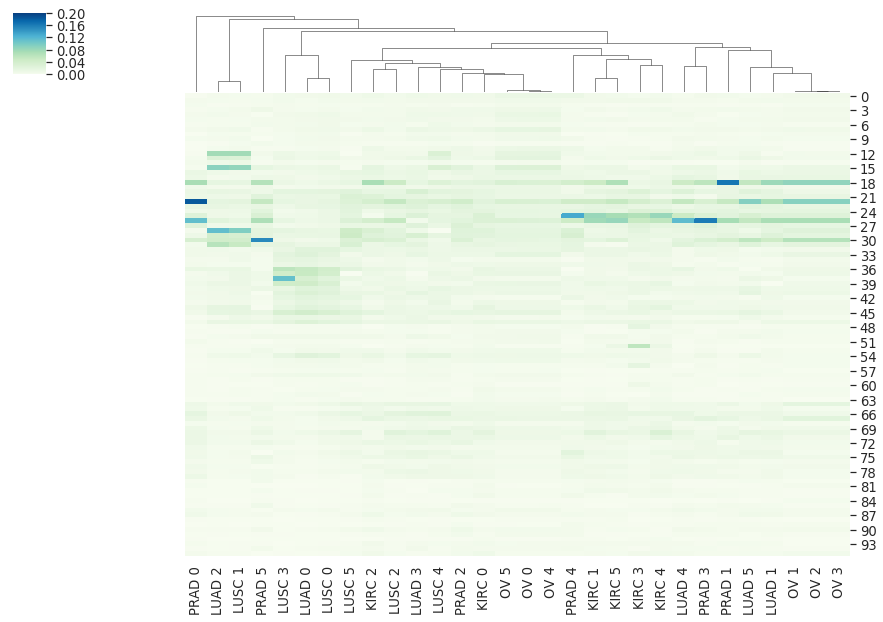

In [63]:
sns.clustermap(signaturesForClustering, figsize=(15, 10), cmap="GnBu", vmin=0, vmax=0.2, row_cluster=False, col_cluster=True);

Based on this clasters are created in the following way: 
- Signature J: PRAD0
- Signature I: LUAD2, LUSC1
- Signature H: PRAD5
- Signature G: LUSC3, LUAD0, LUSC0
- Signature F: LUAD4, PRAD3, LUAD5
- Signature E: LUAD1
- Signature D: PRAD1
- Signature C: OV1, OV2, OV3
- Signature B: PRAD4, KIRC1, KIRC5, KIRC3, KIRC4
- Signature A: LUSC5, KIRC2, LUSC2, LUAD3, LUSC4, PRAD2, KIRC0, OV5, OV0, OV4

It is also interesting to check how other clustering methods can find clusters. For this purpose a t-SNE embedding (so the signatures are embedded into a 2 dimensional space) and K means clustering on the original dataset was done. One can experiencing with this below. However, keeping the same number of signatures as previously, the results will be very similar. (Plot can be seen only if you run it as an .ipynb)

In [68]:
def interactive_cluster(numOfClusters):

    # K-means clustering
    kmeans = KMeans(n_clusters=numOfClusters)
    kMeans = kmeans.fit( WForClustering )
    labels = kMeans.labels_

    # Visualizeing embeddings result
    fig, ax = plt.subplots( figsize=(24, 14) )
    for i in range(0,9):
        ax.scatter(embeddedData[labels == i , 0] , embeddedData[labels == i , 1] , label = i, s=400)
    for i in range(0,30):
        ax.annotate(itemNames[i], (embeddedData[i,0], embeddedData[i,1]), fontsize=16)
    ax.set_xlabel( "Embedding dimension No.1", fontsize=20 )
    ax.set_ylabel( "Embedding dimension No.2", fontsize=20 )
    ax.set_title("Result of t-SNE with K-Means clustering", fontsize=20)

In [69]:
# Performing t-SNE
perplexity = 5.0
tsne = TSNE( n_components=2, perplexity=perplexity )
embeddedData = tsne.fit_transform( WForClustering )

interact(interactive_cluster,
         numOfClusters=IntSlider(value=9, min=1, max=30, step=1, description='Num. of clust.')
        );

interactive(children=(IntSlider(value=9, description='Num. of clust.', max=30, min=1), Output()), _dom_classes=('widget-interact',))

After clustering, the final sigantures were made as an average of the signatures can be found in a cluster.

In [70]:
# Creating the final signatures
signatureA = LUSCW[:,5] + KIRCW[:,2] + LUSCW[:,2] + LUADW[:,3] + LUSCW[:,4] + PRADW[:,2] + KIRCW[:,0] + OVW[:,5] + OVW[:,0] + OVW[:,4]
signatureA = signatureA / np.sum(signatureA)
signatureB = PRADW[:,4] + KIRCW[:,1] + KIRCW[:,5] + KIRCW[:,3] + KIRCW[:,4]
signatureB = signatureB / np.sum(signatureB)
signatureC = OVW[:,1] + OVW[:,2] + OVW[:,3]
signatureC = signatureC / np.sum(signatureC)
signatureD = PRADW[:,1]
signatureD = signatureD / np.sum(signatureD)
signatureE = LUADW[:,1]
signatureE = signatureE / np.sum(signatureE)
signatureF = LUADW[:,4] + PRADW[:,3] + LUADW[:,5]
signatureF = signatureF / np.sum(signatureF)
signatureG = LUSCW[:,3] + LUADW[:,0] + LUSCW[:,0]
signatureG = signatureG / np.sum(signatureG)
signatureH = PRADW[:,5]
signatureH = signatureH / np.sum(signatureH)
signatureI = LUADW[:,2] + LUSCW[:,1]
signatureI = signatureI / np.sum(signatureI)
signatureJ = PRADW[:,0]
signatureJ = signatureJ / np.sum(signatureJ)

In [71]:
cancerSignatureTable = pd.DataFrame(data=np.zeros([10,5]), columns=catalogsOrder, index=["A","B","C","D","E","F","G","H","I","J"])

cancerSignatureTable["LUSC"]["A"] = 1
cancerSignatureTable["KIRC"]["A"] = 1
cancerSignatureTable["LUAD"]["A"] = 1
cancerSignatureTable["PRAD"]["A"] = 1
cancerSignatureTable["OV"]["A"] = 1

cancerSignatureTable["KIRC"]["B"] = 1
cancerSignatureTable["PRAD"]["B"] = 1

cancerSignatureTable["OV"]["C"] = 1

cancerSignatureTable["PRAD"]["D"] = 1

cancerSignatureTable["LUAD"]["E"] = 1

cancerSignatureTable["LUAD"]["F"] = 1
cancerSignatureTable["PRAD"]["F"] = 1

cancerSignatureTable["LUSC"]["G"] = 1
cancerSignatureTable["LUAD"]["G"] = 1

cancerSignatureTable["PRAD"]["H"] = 1

cancerSignatureTable["LUSC"]["I"] = 1
cancerSignatureTable["LUAD"]["I"] = 1

cancerSignatureTable["PRAD"]["J"] = 1

A visualization to show the sigantures can be found in a given cancer type was made and can be seen below. Here green square shows that signature is present in a cancer type and red square shows that signature is not present in a cancer type.

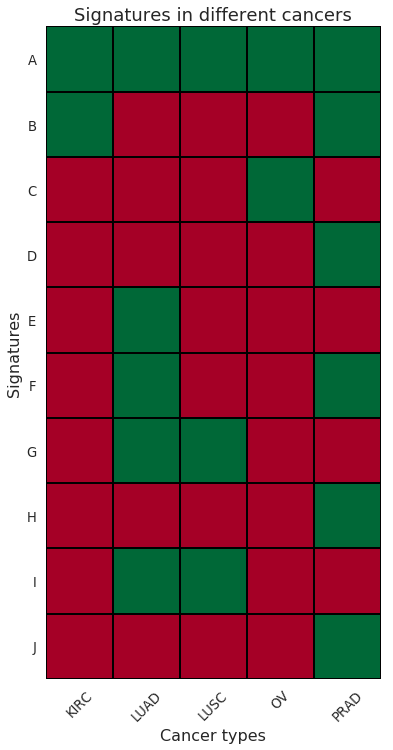

In [72]:
plt.figure( figsize=(6,12) )
plt.title( "Signatures in different cancers", fontsize = TITLE_SIZE );
sns.heatmap( cancerSignatureTable, xticklabels=cancerSignatureTable.columns, yticklabels=cancerSignatureTable.index,
            robust=True, fmt="d", linewidths=1, linecolor="black", cmap="RdYlGn", cbar=False )
plt.yticks( rotation=0 )
plt.ylabel("Signatures", fontsize=LABEL_SIZE)
plt.xlabel("Cancer types", fontsize=LABEL_SIZE)
plt.xticks( rotation=45 )
plt.show()

In [73]:
def signature_bars(x,y):

    colors = ["maroon"]*16 + ["darkblue"]*16 + ["orange"]*16 + ["darkgreen"]*16 + ["crimson"]*16 + ["dodgerblue"]*16

    fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(18, 6) )
    fig.tight_layout(pad=4.5)
    indexes = x
    x = []
    for i in range(0,len(indexes)):
        if( i%2==0 ):
            x.append(indexes[i] + "               ")
        else:
            x.append("               " + indexes[i])
    y = y/sum(y)
    #sns.barplot(x=x, y=y, palette="Set1", linewidth=2, edgecolor=".4", ax=ax)
    ax.bar(x=x, height=y, width=1, color=colors)
    ax.set_xlabel("Mutation", fontsize=1.3*LABEL_SIZE)
    ax.set_ylabel("Percentage of mutations", fontsize=1.3*LABEL_SIZE)
    ax.set_ylim([0,0.20])
    ax.tick_params(labelrotation=90, labelsize=15)
    ax.locator_params(axis='y', nbins=6)
    ax.text(0.09, 0.95, "C>G", transform=ax.transAxes, fontsize=32, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='maroon', alpha=0.6))
    ax.text(0.24, 0.95, "C>T", transform=ax.transAxes, fontsize=32, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='darkblue', alpha=0.6))
    ax.text(0.39, 0.95, "C>A", transform=ax.transAxes, fontsize=32, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='orange', alpha=0.6))
    ax.text(0.54, 0.95, "T>A", transform=ax.transAxes, fontsize=32, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='darkgreen', alpha=0.6))
    ax.text(0.69, 0.95, "T>C", transform=ax.transAxes, fontsize=32, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='crimson', alpha=0.6))
    ax.text(0.84, 0.95, "T>G", transform=ax.transAxes, fontsize=32, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='dodgerblue', alpha=0.6))
    plt.show()
#ax.set_title(keys[i], fontsize=TITLE_SIZE)

Different signatures are visualized here (can be seen only if you run it as an .ipynb):

In [74]:
def interactive_signature(signatureType):
    types = {"A": signatureA, "B": signatureB, "C": signatureC, "D": signatureD, "E": signatureE,
             "F": signatureF, "G": signatureG, "H": signatureH, "I": signatureI, "J": signatureJ}
    signature_bars(mutationalClasses, types.get(signatureType))

interact(interactive_signature,
         signatureType=Dropdown(options=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],description='Sign. type')
        );

interactive(children=(Dropdown(description='Sign. type', options=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'), value='A'), Output()), _dom_classes=('widget-interact',))

It is interesting, signature G is present only in different lung cancers, and here C>A mutations are overrepresented. Nowadays it is known smoking can lead to C>A mutations, so it is an example of the relationship between smoking and lung cancers.

### 8) Signature contribution to cancer types

Finally, we are going to check the average contribution of different signatures to different cancer types. On the piecharts below one can see this. To determine the contribution of different signatures, it was calculated from the results based on the non-negative matrix factorization and the results of the clustering. (Plot can be seen only if you run it as an .ipynb)

In [78]:
KIRCContr = KIRCH.sum(axis=1)/np.sum(KIRCH.sum(axis=1))
KIRCSignA = KIRCContr[0]+KIRCContr[2]
KIRCSignB = KIRCContr[1]+KIRCContr[3]+KIRCContr[4]+KIRCContr[5]
KIRCSigns = {"Signature A": KIRCSignA, "Signature B": KIRCSignB}

LUADContr = LUADH.sum(axis=1)/np.sum(LUADH.sum(axis=1))
LUADSignA = LUADContr[3]
LUADSignE = LUADContr[1]
LUADSignF = LUADContr[4]+LUADContr[5]
LUADSignG = LUADContr[0]
LUADSignI = LUADContr[2]
LUADSigns = {"Signature A": LUADSignA, "Signature E": LUADSignE, "Signature F": LUADSignF,
             "Signature G": LUADSignG, "Signature I": LUADSignI}

LUSCContr = LUSCH.sum(axis=1)/np.sum(LUSCH.sum(axis=1))
LUSCSignA = LUSCContr[2]+LUSCContr[4]+LUSCContr[5]
LUSCSignG = LUSCContr[0]+LUSCContr[3]
LUSCSignI = LUSCContr[1]
LUSCSigns = {"Signature A": LUSCSignA, "Signature G": LUSCSignG, "Signature I": LUSCSignI}

OVContr = OVH.sum(axis=1)/np.sum(OVH.sum(axis=1))
OVSignA = OVContr[0]+OVContr[4]+OVContr[5]
OVSignC = OVContr[1]+OVContr[2]+OVContr[3]
OVSigns = {"Signature A": OVSignA, "Signature C": OVSignC}

PRADContr = PRADH.sum(axis=1)/np.sum(PRADH.sum(axis=1))
PRADSignA = PRADContr[2]
PRADSignB = PRADContr[4]
PRADSignD = PRADContr[1]
PRADSignF = PRADContr[3]
PRADSignH = PRADContr[5]
PRADSignJ = PRADContr[0]
PRADSigns = {"Signature A": PRADSignA, "Signature B": PRADSignB, "Signature D": PRADSignD,
             "Signature F": PRADSignF, "Signature H": PRADSignH, "Signature J": PRADSignJ}

In [79]:
def signature_pie(cancerType):

    types = {"KIRC": KIRCSigns, "LUAD": LUADSigns, "LUSC": LUSCSigns, "OV": OVSigns, "PRAD": PRADSigns}
    labels = list(types.get(cancerType).keys())
    values = list(types.get(cancerType).values())

    plt.figure( figsize = (8,8))
    plt.pie(values, labels=labels)
    plt.axis('equal')
    plt.show()

In [80]:
interact(signature_pie,
         cancerType=Dropdown(options=['KIRC', 'LUAD', 'LUSC', 'OV', 'PRAD'],description='Cancer type')
        );

interactive(children=(Dropdown(description='Cancer type', options=('KIRC', 'LUAD', 'LUSC', 'OV', 'PRAD'), value='KIRC'), Output()), _dom_classes=('widget-interact',))

Here one can see again, the main signature contribution to different lung cancers comes from Signature G, which is dominated by C>A mutations.